In [1]:
import typing

import numpy as np
import pandas as pd

from scipy.optimize import curve_fit
from pandas import Grouper as tg

import pangho

import interpretable as inter
import interpretable_linear_data as interData

import tqdm.auto as tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt 

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from sklearn.metrics import r2_score

In [2]:
# load clean data
#df = pd.read_csv('january_data_2019.csv', index_col=0)
%store -r dfSPMINI

In [3]:
# we store the desired data
mid = dfSPMINI['mid'][:2000000].copy()
returns = dfSPMINI['returns'][:2000000].copy()
qty_signed = dfSPMINI['qty_signed'][:2000000].copy()
epsilons = qty_signed.apply(lambda x: np.sign(x)).copy()

In [4]:
# we set the learning lag parameter
N = len(dfSPMINI)
max_lag = 1000

In [5]:
def f2(v,a,b):
    return a*np.power(v,-b)
def f3(v,a,b):
    return a*v+b

In [6]:
# trades autcovariance 
acf_epsilonsSPMINI = inter.autocovariance(epsilons.values , max_lag)

# curve fitting 
params2, cov = curve_fit(f2, np.arange(1,max_lag+1), acf_epsilonsSPMINI[1:] )


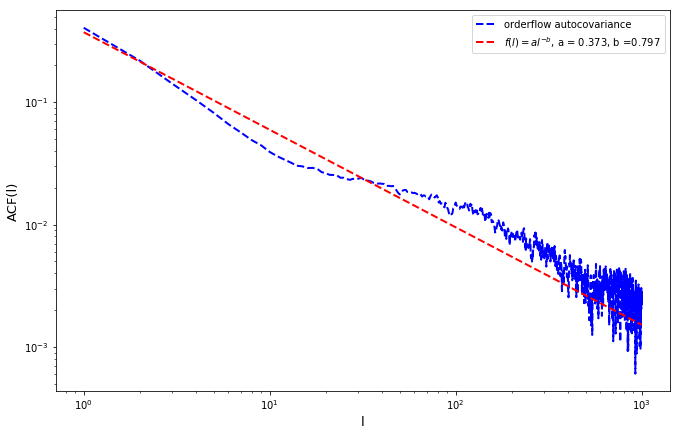

In [7]:
# plot
fig, (ax1) = plt.subplots(1, 1, figsize=[11, 7])

appro = f2(np.arange(1,N+1), *params2)
ax1.plot(np.arange(1,max_lag+1), acf_epsilonsSPMINI[1:], '--b', linewidth=2, label ='orderflow autocovariance')
ax1.plot(np.arange(1,max_lag+1), appro[:max_lag], '--r', linewidth=2, 
label = r'$f(l) = al^{-b}$' + ', a = ' + str(params2[0])[:5] + ', b =' + str(params2[1])[:5] )
ax1.set_xlabel('l', fontsize=13)
ax1.set_ylabel('ACF(l)', fontsize=13)
ax1.legend()
ax1.set_xscale('log')
ax1.set_yscale('log')
#ax1.set_xlim((0,1000))

#plt.savefig('graphs_10YUSB/order_flow_autocovariance_function_10YUSB.png')
plt.savefig('graphs_SPMINI/order_flow_autocovariance_function_SPMINI.png')
plt.show()

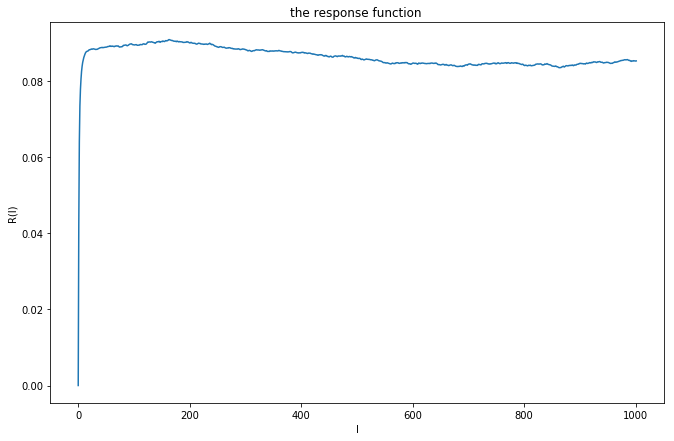

In [8]:
# response function 

ResSPMINI = inter.response_function(epsilons.values, mid.values, max_lag+1)

# plot
fig, (ax1) = plt.subplots(1, 1, figsize=[11, 7])

ax1.plot(ResSPMINI)
ax1.set_title('the response function ')
ax1.set_xlabel('l')
ax1.set_ylabel('R(l)')

#plt.savefig('graphs_10YUSB/response_function_10YUSB.png')
plt.savefig('graphs_SPMINI/response_function_SPMINI.png')

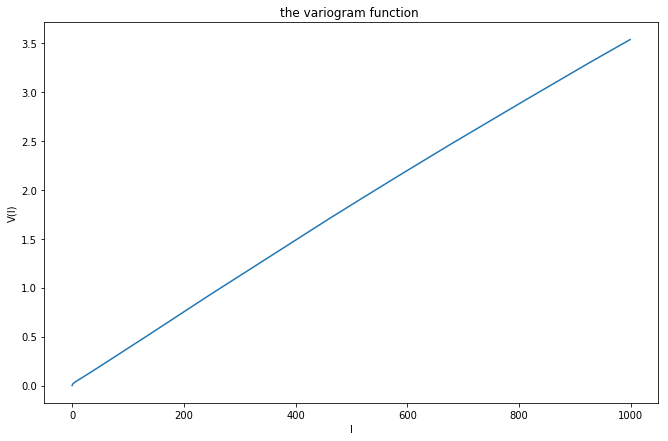

In [9]:
# the variogram
VarioSPMINI = inter.variogram2(mid.values, max_lag)

# plot 
fig, (ax1) = plt.subplots(1, 1, figsize=[11, 7])

ax1.plot(VarioSPMINI)

ax1.set_title('the variogram function ')
ax1.set_xlabel('l')
ax1.set_ylabel('V(l)')
#ax1.legend()


#plt.savefig('graphs_10YUSB/variogram_function_10YUSB.png')
plt.savefig('graphs_SPMINI/variogram_function_SPMINI.png')

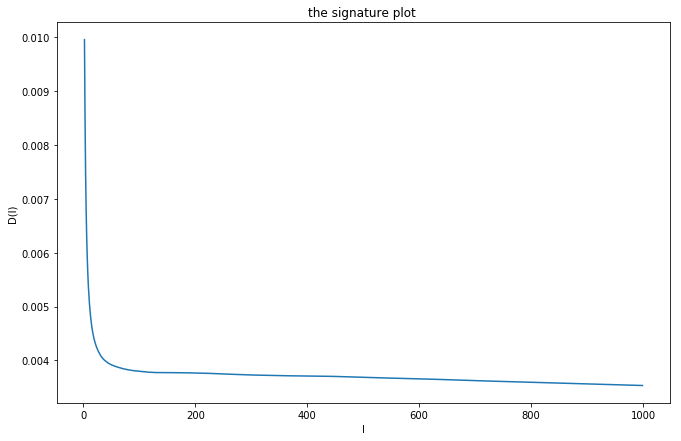

In [10]:
# signature plot 

signature_plot = VarioSPMINI[1:]/np.arange(1,len(VarioSPMINI))

# plot 
fig, (ax1) = plt.subplots(1, 1, figsize=[11, 7])

ax1.plot(signature_plot[1:])
ax1.set_title('the signature plot ')
ax1.set_xlabel('l')
ax1.set_ylabel('D(l)')
#ax1.legend()

#plt.savefig('graphs_10YUSB/signature_plot_10YUSB.png')
plt.savefig('graphs_SPMINI/signature_plot_SPMINI.png')

In [11]:
# we can start the kernel regression

# linear regression

# we define the regression matrix

L = 500

A = inter.regression_matrix(epsilons.values, L-1)
#row_std = A.std(axis=1)
#new_matrix = A #/ row_std[:, np.newaxis]
Y = returns.values[L-1:]

from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(A, Y)
K_star = reg.coef_
K_star = pd.Series(K_star)

G_starSPMINI = pd.concat((pd.Series([0]), K_star.cumsum()))

# problem inversion

#S = Res.diff().dropna() # do not work it is the proof that the model is wrong 
S = inter.sign_return_correlation2(returns, epsilons, len(ResSPMINI))

K_approx = inter.problem_inversion(S, np.linalg.inv(inter.covariance_matrix(acf_epsilonsSPMINI, L)), L)

G_approxSPMINI = pd.concat((pd.Series([0]), K_approx.cumsum()))

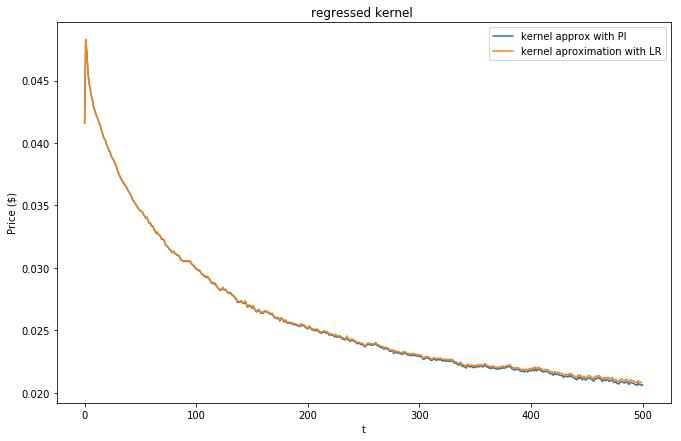

In [12]:
fig, (ax1) = plt.subplots(1, 1, figsize=[11, 7])

ax1.plot(G_approxSPMINI[1:], label = 'kernel approx with PI')
ax1.plot(G_starSPMINI[1:], label = 'kernel aproximation with LR')
ax1.set_title('regressed kernel ')
ax1.set_xlabel('t')
ax1.set_ylabel('Price ($)')
#ax1.set_xlim((1,500))
ax1.legend()

#plt.savefig('graphs_10YUSB/linear_regression_kernels_10YUSB.png')
plt.savefig('graphs_SPMINI/linear_regression_kernels_SPMINI.png')

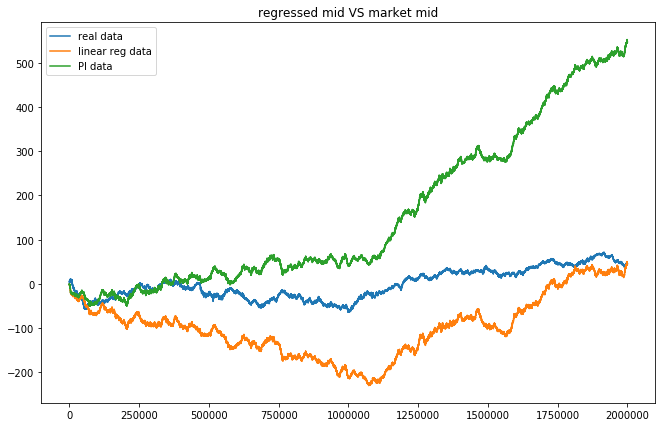

In [13]:
noise = np.random.normal(0,0, len(returns))
m = 10000
new_data_reg = pd.Series(reg.predict(A))
new_data_PI = pd.Series(inter.generator(epsilons.values, G_approxSPMINI, noise, L-1)).loc[L-1:]
fig, (ax1) = plt.subplots(1, 1, figsize=[11, 7])

ax1.plot(Y.cumsum(), label = 'real data')
ax1.plot( new_data_reg.values.cumsum(), label = 'linear reg data' )
ax1.plot( new_data_PI.values.cumsum(), label = 'PI data' )
ax1.set_title('regressed mid VS market mid')
ax1.legend()

#plt.savefig('graphs_10YUSB/linear_mid_comparison_10YUSB.png')
plt.savefig('graphs_SPMINI/linear_mid_comparison_SPMINI.png')

In [14]:
synthetic_variogram_GstarSPMINI_approx_epsilons = inter.variogram2(new_data_reg.cumsum())
R2_GstarSPMINI_approx_epsilons = inter.R2(Y, new_data_reg)
% store synthetic_variogram_GstarSPMINI_approx_epsilons
% store new_data_reg
% store R2_GstarSPMINI_approx_epsilons


Stored 'synthetic_variogram_GstarSPMINI_approx_epsilons' (Series)
Stored 'new_data_reg' (Series)
Stored 'R2_GstarSPMINI_approx_epsilons' (Series)


In [15]:
inter.R2(Y, new_data_reg)

0    0.159674
dtype: float64

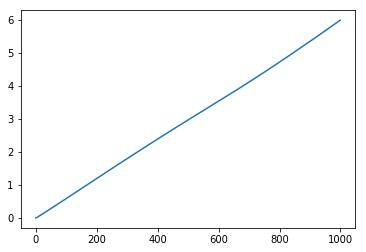

In [16]:
plt.plot(synthetic_variogram_GstarSPMINI_approx_epsilons)

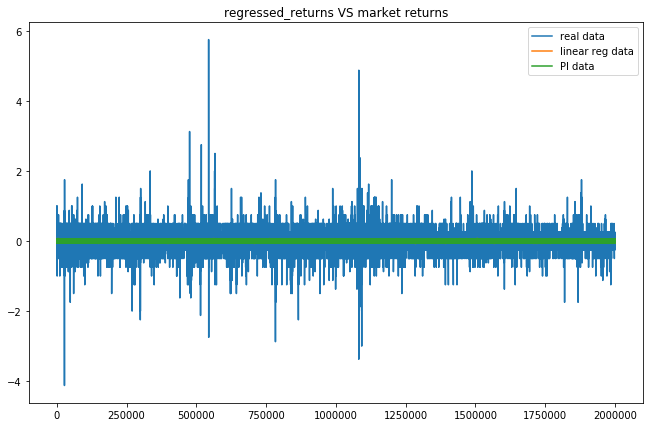

In [18]:
fig, (ax1) = plt.subplots(1, 1, figsize=[11, 7])

ax1.plot(Y, label = 'real data')
ax1.plot(  (new_data_reg), label = 'linear reg data' )
ax1.plot( (new_data_PI).values, label = 'PI data' )
ax1.set_title('regressed_returns VS market returns')
ax1.legend()

#plt.savefig('graphs_10YUSB/linear_returns_comparison_10YUSB.png')
plt.savefig('graphs_SPMINI/linear_returns_comparison_SPMINI.png')

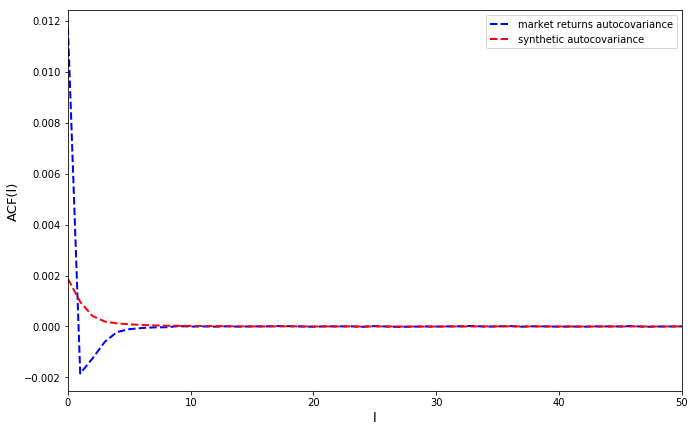

In [19]:
# plot
fig, (ax1) = plt.subplots(1, 1, figsize=[11, 7])

appro = f2(np.arange(1,N+1), *params2)
ax1.plot(inter.autocovariance(Y, max_lag), '--b', linewidth=2, label ='market returns autocovariance')
ax1.plot(inter.autocovariance(new_data_reg.values, max_lag), '--r', linewidth=2, label ='synthetic autocovariance')
ax1.set_xlabel('l', fontsize=13)
ax1.set_ylabel('ACF(l)', fontsize=13)
ax1.legend()
#ax1.set_xscale('log')
#ax1.set_yscale('log')
ax1.set_xlim((0,50))

#plt.savefig('graphs_10YUSB/linear_returns_autocovariance_function_10YUSB.png')
plt.savefig('graphs_SPMINI/linear_returns_autocovariance_function_SPMINI.png')

plt.show()

$\underline{\text{Single-layer NN} }$

In [20]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.constraints import NonNeg 

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from sklearn import preprocessing


In [21]:
# we aplly the kernel constraints
class NonNegativeCumsum(tf.keras.constraints.Constraint):

    def __call__(self, w):
        return w * tf.cast(tf.math.greater_equal(tf.math.cumsum(w), 0.), w.dtype)
    
def plot_loss(ax, history):
    ax.semilogy(history.history['loss'], label='loss')
    ax.semilogy(history.history['val_loss'], label='val_loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Error')
    ax.legend()
    ax.grid(True)

In [22]:
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.0001)
#optimizer = tf.optimizers.Adam(learning_rate = 0.0001)
#optimizer = tf.keras.optimizers.Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08, decay = 0.01)
batch_size = int(N/1000)
callback = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 5)

In [23]:
def normalize_rows(x: np.ndarray):
    return x/np.linalg.norm(x, ord=2, axis=1, keepdims=True)

In [24]:
train_norm = pd.DataFrame(A)

linear_model2 = Sequential()
linear_model2.add(tf.keras.layers.Dense(units = 1, 
                                        kernel_constraint = NonNegativeCumsum(), 
                                        use_bias = False,
                                        dtype = 'float64')
                        )


linear_model2.compile(optimizer = optimizer,
                             loss = "mean_squared_error")
     
history2 = linear_model2.fit(train_norm,
                               Y,
                               epochs = 200,
                               # We do not suppress logging.
                               verbose = 1,
                               # Calculate validation results on 30% of the training data.
                               validation_split = 0.3,
                               batch_size = batch_size,
                               callbacks = [callback]
                              )
linear_model2.summary()

Epoch 1/200
225/225 [==============================] - 5s 20ms/step - loss: 0.2588 - val_loss: 0.2373
Epoch 2/200
225/225 [==============================] - 2s 9ms/step - loss: 0.2239 - val_loss: 0.2119
Epoch 3/200
225/225 [==============================] - 2s 10ms/step - loss: 0.2010 - val_loss: 0.1899
Epoch 4/200
225/225 [==============================] - 2s 10ms/step - loss: 0.1812 - val_loss: 0.1708
Epoch 5/200
225/225 [==============================] - 2s 10ms/step - loss: 0.1639 - val_loss: 0.1542
Epoch 6/200
225/225 [==============================] - 2s 10ms/step - loss: 0.1487 - val_loss: 0.1398
Epoch 7/200
225/225 [==============================] - 2s 10ms/step - loss: 0.1355 - val_loss: 0.1271
Epoch 8/200
225/225 [==============================] - 2s 10ms/step - loss: 0.1238 - val_loss: 0.1159
Epoch 9/200
225/225 [==============================] - 2s 10ms/step - loss: 0.1135 - val_loss: 0.1061
Epoch 10/200
225/225 [==============================] - 2s 10ms/step - loss: 0.1044

225/225 [==============================] - 2s 9ms/step - loss: 0.0118 - val_loss: 0.0103
Epoch 82/200
225/225 [==============================] - 2s 9ms/step - loss: 0.0117 - val_loss: 0.0102
Epoch 83/200
225/225 [==============================] - 2s 9ms/step - loss: 0.0117 - val_loss: 0.0102
Epoch 84/200
225/225 [==============================] - 2s 9ms/step - loss: 0.0116 - val_loss: 0.0101
Epoch 85/200
225/225 [==============================] - 2s 9ms/step - loss: 0.0116 - val_loss: 0.0101
Epoch 86/200
225/225 [==============================] - 2s 9ms/step - loss: 0.0115 - val_loss: 0.0100
Epoch 87/200
225/225 [==============================] - 2s 9ms/step - loss: 0.0114 - val_loss: 0.0100
Epoch 88/200
225/225 [==============================] - 2s 9ms/step - loss: 0.0114 - val_loss: 0.0099
Epoch 89/200
225/225 [==============================] - 2s 9ms/step - loss: 0.0113 - val_loss: 0.0099
Epoch 90/200
225/225 [==============================] - 2s 9ms/step - loss: 0.0113 - val_loss: 

Epoch 161/200
225/225 [==============================] - 2s 9ms/step - loss: 0.0103 - val_loss: 0.0089
Epoch 162/200
225/225 [==============================] - 2s 9ms/step - loss: 0.0103 - val_loss: 0.0089
Epoch 163/200
225/225 [==============================] - 2s 9ms/step - loss: 0.0103 - val_loss: 0.0089
Epoch 164/200
225/225 [==============================] - 2s 9ms/step - loss: 0.0103 - val_loss: 0.0089
Epoch 165/200
225/225 [==============================] - 2s 9ms/step - loss: 0.0103 - val_loss: 0.0089
Epoch 166/200
225/225 [==============================] - 2s 9ms/step - loss: 0.0103 - val_loss: 0.0089
Epoch 167/200
225/225 [==============================] - 2s 9ms/step - loss: 0.0103 - val_loss: 0.0089
Epoch 168/200
225/225 [==============================] - 2s 9ms/step - loss: 0.0103 - val_loss: 0.0089
Epoch 169/200
225/225 [==============================] - 2s 9ms/step - loss: 0.0103 - val_loss: 0.0089
Epoch 170/200
225/225 [==============================] - 2s 9ms/step - lo

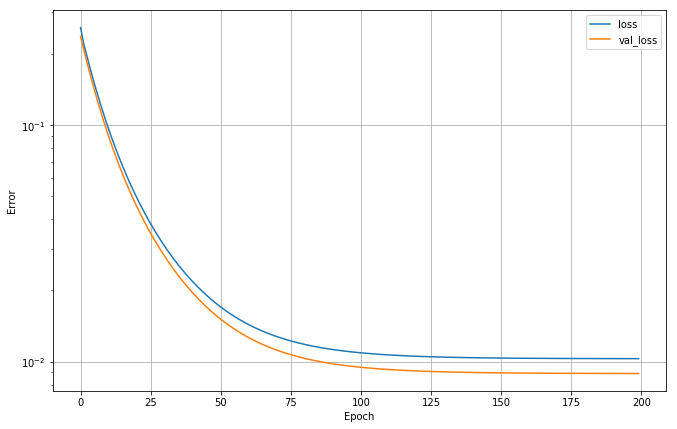

In [25]:
# we plot the loss on validation set and training set on each batch
fig, (ax1) = plt.subplots(1, 1, figsize=[11, 7])
plot_loss(ax1, history2)
#plt.savefig('graphs_10YUSB/NN2_loss_kernel_10YUSB.png')
plt.savefig('graphs_SPMINI/NN2_loss_kernel_SPMINI.png')

In [26]:
GNN_approxSPMINI_epsilons = pd.concat((pd.Series([0]), pd.Series(linear_model2.layers[0].kernel.numpy().cumsum())))

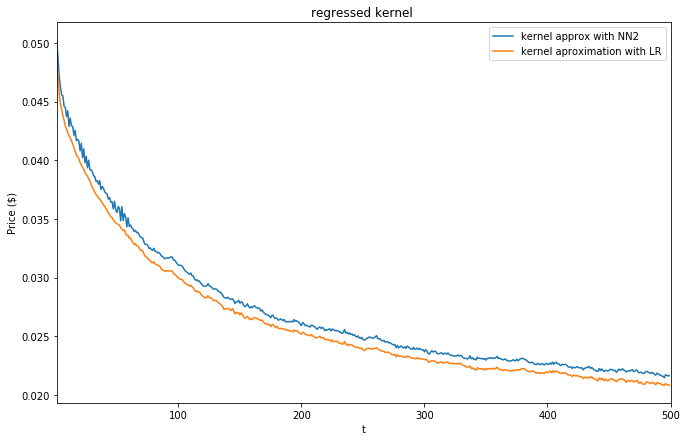

In [27]:
fig, (ax1) = plt.subplots(1, 1, figsize=[11, 7])
#GNN2_approx[1:]
#GNN1_approx[1:]
ax1.plot(GNN_approxSPMINI_epsilons[1:], label = 'kernel approx with NN2')
#ax1.plot(GNN1_approx[1:], label = 'kernel approx with NN1')
#ax1.plot(G_approx[1:], label = 'kernel approx with PI')
ax1.plot(G_starSPMINI[1:], label = 'kernel aproximation with LR')
ax1.set_title('regressed kernel ')
ax1.set_xlabel('t')
ax1.set_ylabel('Price ($)')
ax1.set_xlim((1,500))
#ax1.set_ylim((0,0.5))
ax1.legend()

#plt.savefig('graphs_10YUSB/NN_regression_kernel_10YUSB.png')
plt.savefig('graphs_SPMINI/NN_regression_kernel_SPMINI.png')

In [28]:
YNN2_pred = linear_model2.predict(train_norm)
synthetic_variogram_GNN_approx_epsilons = inter.variogram2(YNN2_pred.cumsum())

In [29]:
R2_GNNSPMINI_approx_epsilons = r2_score(Y, YNN2_pred.reshape((len(Y),-1)))
% store YNN2_pred

Stored 'YNN2_pred' (ndarray)


In [30]:
R2_GNNSPMINI_approx_epsilons

0.1586698117026254

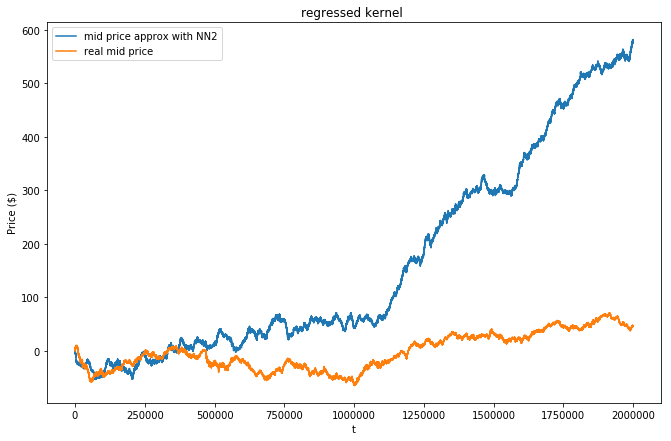

In [31]:
fig, (ax1) = plt.subplots(1, 1, figsize = [11, 7])

ax1.plot(YNN2_pred.cumsum(), label = 'mid price approx with NN2')
#ax1.plot(YLR_pred.cumsum(), label = 'mid price approx with reglin')
ax1.plot(Y.cumsum(), label = 'real mid price ')
ax1.set_title('regressed kernel ')
ax1.set_xlabel('t')
ax1.set_ylabel('Price ($)')
#ax1.set_xlim((1,1000))
ax1.legend()

#plt.savefig('graphs_10YUSB/mid_comparative_10YUSB.png')
plt.savefig('graphs_SPMINI/mid_comparative_SPMINI.png')

In [32]:
G_starSPMINI_epsilons = G_starSPMINI

In [33]:
G_approxSPMINI_epsilons = G_approxSPMINI

In [34]:
YNN_SPMINI_epsilons = YNN2_pred

In [35]:
YLR_approx_epsilons = new_data_reg

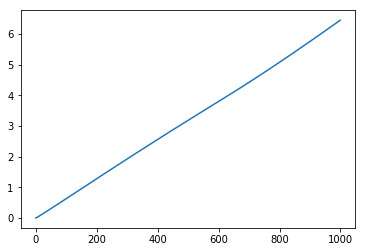

In [36]:
plt.plot(synthetic_variogram_GNN_approx_epsilons)

In [37]:
# data to store:

# autocovariance
% store acf_epsilonsSPMINI

# response
% store ResSPMINI

# signature plot + variogram
% store VarioSPMINI

# kernels
% store G_starSPMINI_epsilons
% store G_approxSPMINI_epsilons
% store GNN_approxSPMINI_epsilons

# synthetic variograms
% store synthetic_variogram_GstarSPMINI_approx_epsilons
% store synthetic_variogram_GNN_approx_epsilons

# R squared
% store R2_GstarSPMINI_approx_epsilons
% store R2_GNNSPMINI_approx_epsilons

# synthetic returns
% store YNN_SPMINI_epsilons
% store YLR_approx_epsilons

Stored 'acf_epsilonsSPMINI' (Series)
Stored 'ResSPMINI' (Series)
Stored 'VarioSPMINI' (Series)
Stored 'G_starSPMINI_epsilons' (Series)
Stored 'G_approxSPMINI_epsilons' (Series)
Stored 'GNN_approxSPMINI_epsilons' (Series)
Stored 'synthetic_variogram_GstarSPMINI_approx_epsilons' (Series)
Stored 'synthetic_variogram_GNN_approx_epsilons' (Series)
Stored 'R2_GstarSPMINI_approx_epsilons' (Series)
Stored 'R2_GNNSPMINI_approx_epsilons' (float64)
Stored 'YNN_SPMINI_epsilons' (ndarray)
Stored 'YLR_approx_epsilons' (Series)
